### GW tutorial 2: Detector noise and GW150914

Author: Melissa Lopez

Email: m.lopez@uu.nl

Note that we are importing some packages to be able to read the data.

In [ ]:
!pip install pycbc

In [ ]:
%matplotlib inline
from pycbc.catalog import Merger
import pycbc.psd
import pylab
import matplotlib.pyplot as plt
import numpy as np

In the previous part we have seen the detector response to gravitational waves (GW). Currently, we have three ground-based detectors: LIGO Hanford (H1), LIGO Livingston (L1) and Virgo (V1). But what does the data actually look like?

To answer this question we are going to take a look at the first detection: **GW150914**. Let's load the data from L1

In [ ]:
detection_id = 'GW150914'
m = Merger(detection_id)
ifo = 'L1'
data = m.strain(ifo)

**Exercise 1:** We can see that this object is a PyCBC timeseries, and as such you can check what their atributes are (see [here](https://pycbc.org/pycbc/latest/html/pycbc.types.html#module-pycbc.types.timeseries)). Let's check some of them.

- How much is the duration of the time series?

- How much is its sampling rate?

- How many data points does it have?

- How much is $\Delta_{f}$ and $\Delta_{t}$? Can you find a relation between these and the number of data points?

_Hint:_ $\Delta_{f} = 1/duration$ and  $\Delta_{t} = 1/sample\_rate$

In [ ]:
print(f"Detection: {detection_id}\n")


duration = data.duration  # Total duration of the time series in seconds
samp_rate = data.sample_rate  # Sampling rate in Hz (samples per second)

delta_f = 1. / duration  # Frequency resolution (spacing between frequency bins in Hz)
delta_t = 1. / samp_rate  # Time resolution (spacing between time samples in seconds)

print(f"Duration of time series: {duration} s")
print(f"Sampling Rate: {samp_rate} Hz")
print(f"Data points: {data.shape[0]}")
print(f"Delta_f: {delta_f} Hz")
print(f"Delta_t: {delta_t} s")

Detection: GW150914

Duration of time series: 32.0 s
Sampling Rate: 4096.0 Hz
Data points: 131072
Delta_f: 0.03125 Hz
Delta_t: 0.000244140625 s


The previous magnitudes are key parameters of the timeseries. Now, let's plot the actual data to see what it looks like.

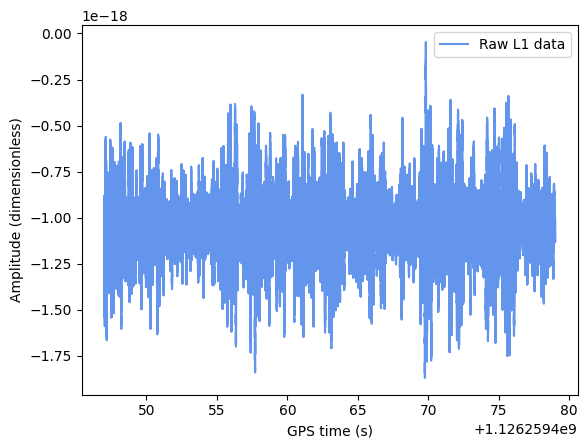

In [ ]:
plt.plot(data.sample_times, data, label='Raw L1 data', color='cornflowerblue')
plt.xlabel('GPS time (s)')
plt.ylabel('Amplitude (dimensionless)')
plt.legend()

In GW we use the GPS time to determine at what time the GW signals reached Earth. You can see that the amplitude of this data is super small, $\mathcal{O}(10^{-18})$! GW interferometers are able to detect a change in distance of ~1/10,000th the size of a proton.

But, where is GW190514? We cannot see it (yet) as there are many different contributions from the detector. The detector has a given "noise budget" given  by the power spectral density (PSD), $S_{n}(f)$, according to its specific design.

**Exercise 2**: Estimate the PSD of the data using `filter_psd` (see [here](https://pycbc.org/pycbc/latest/html/pycbc.types.html#pycbc.types.timeseries.TimeSeries.filter_psd)) and plot it. Limit your plot according to the minimum frequency (say, 1 Hz) and  the Nyquist frequency.

_Hint_: Note that the PSD is a frequency series.

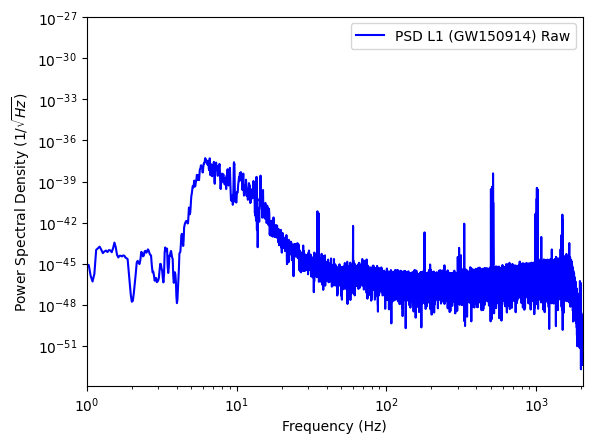

In [ ]:

flow = 1 #Hz - (Low frequency cutoff)

psd = data.filter_psd(duration, delta_f, flow) #Power Spectral Density

#Make plot aplying log scaling to both axis:
plt.loglog(psd.get_sample_frequencies(), psd, label=f"PSD L1 ({detection_id}) Raw", color="blue")

#Plot limits (1Hz - Nyquist frequency)
plt.xlim(1, samp_rate/2) #(Nyquist theorem)

plt.xlabel("Frequency (Hz)")
plt.ylabel(r"Power Spectral Density $(1/\sqrt {Hz})$")
plt.legend()


The PSD shows us what are the different contributions of the detector noise.
While we computed the PSD from 1 Hz, you can see that there is a weird behaviour for frequencies < 5 Hz. This is because the detector is not calibrated at these frequencies, so our analysis needs to start at higher frequencies. For current ground based detectors, we usually start at 10 Hz or higher, depending on the source.

GW signals are tiny, so with this much noise we won't be able to see GW150914. To "flatten" all frequency contributions we whiten the data.

**Exercise 3:** We can whiten the data with [this](https://pycbc.org/pycbc/latest/html/pycbc.types.html#pycbc.types.timeseries.TimeSeries.whiten) function. Use `segment_duration = 4` and `max_filter_duration=4`.

- Plot the whitened data next to the raw detector noise. What differences can you see?

- Estimate the PSD of the whitened data. Plot it in the same graph as the raw PSD. What differences can you see?


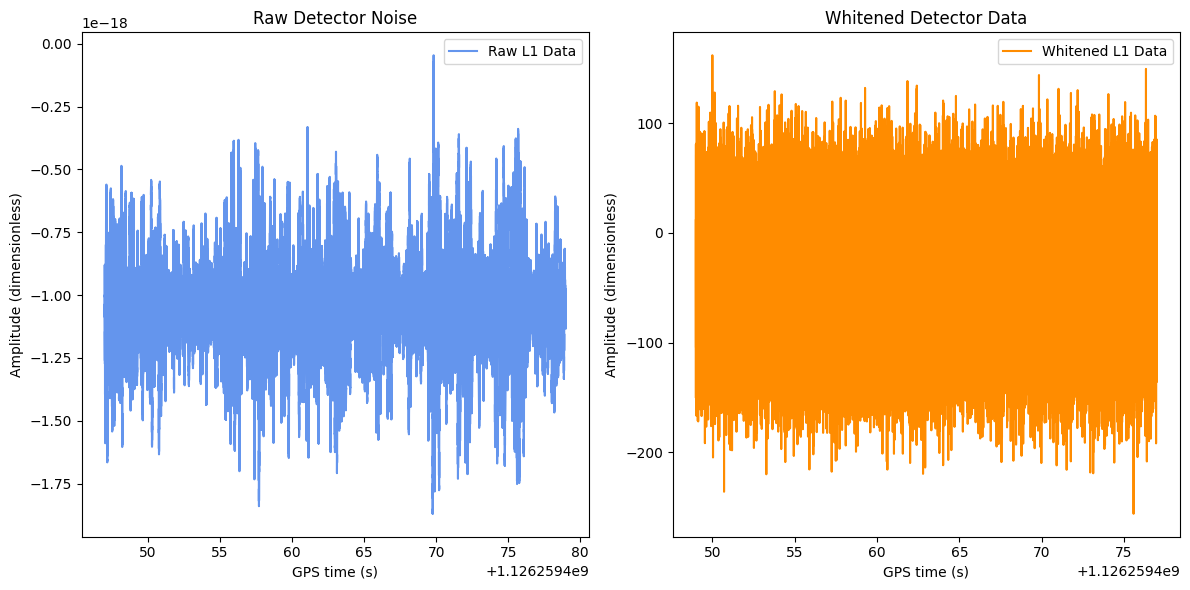

'\nplt.loglog(psd.get_sample_frequencies(), psd, label=\'Raw PSD\', color=\'blue\')\nplt.loglog(whitened_psd.get_sample_frequencies (), whitened_psd, label="Whitened PSD", color= "orange")\n\nplt.xlim(flow, data.sample_rate/2)\nplt.xlabel(\'Frequency (Hz)\')\nplt.ylabel(\'PSD\')\nplt.legend()\nplt.title(\'Comparison of Raw and Whitened PSD\')\nplt.grid(which=\'both\', linestyle=\'--\', linewidth=0.5)\nplt.show()'

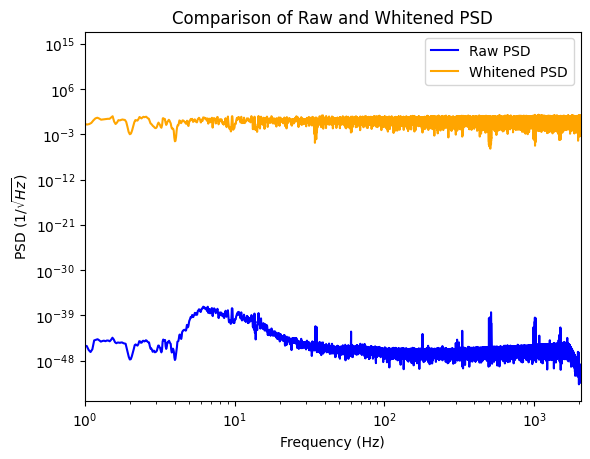

In [ ]:
# Whitening the data
segment_duration = 4
max_filter_duration = 4

whitened_data = data.whiten(segment_duration, max_filter_duration)

# Plot raw and whitened data
fig = plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(data.sample_times, data, label="Raw L1 Data", color="cornflowerblue")
plt.xlabel("GPS time (s)")
plt.ylabel("Amplitude (dimensionless)")
plt.legend()
plt.title('Raw Detector Noise')

plt.subplot(1,2,2)
plt.plot(whitened_data.sample_times, whitened_data, label='Whitened L1 Data', color='darkorange')
plt.xlabel("GPS time (s)")
plt.ylabel("Amplitude (dimensionless)")
plt.legend()
plt.title("Whitened Detector Data")

plt.tight_layout()
plt.show()


#========================================================================

# Compute PSD of whitened data
whitened_psd = whitened_data.filter_psd(whitened_data.duration, whitened_data.delta_f, flow=1)

plt.loglog(psd.get_sample_frequencies(), psd, label='Raw PSD', color='blue')
plt.loglog(whitened_psd.get_sample_frequencies (), whitened_psd, label="Whitened PSD", color= "orange")

plt.xlim(flow, data.sample_rate/2) #flow = 1
plt.xlabel("Frequency (Hz)")
plt.ylabel(r"PSD $(1/\sqrt {Hz})$")
plt.legend ()
plt.title("Comparison of Raw and Whitened PSD")




Now all frequency contributions are at the same level, as we can see from the PSD. However, GW150914 is still hidden in the data.


**Exercise 4:** We can apply a [low pass filter](https://pycbc.org/pycbc/latest/html/pycbc.types.html#pycbc.types.timeseries.TimeSeries.lowpass_fir) and a [high pass filter](https://pycbc.org/pycbc/latest/html/pycbc.types.html#pycbc.types.timeseries.TimeSeries.highpass_fir) to limit the frequency of the data. The low pass filters above 250 Hz (order=512) and the high pass filters below 30 Hz (order=512).

- Estimate the PSD of the bandpassed data and plot it together with the raw PSD and the whitened PSD. What is the bandpass doing?

- Plot the bandpassed data [cropping](https://pycbc.org/pycbc/latest/html/pycbc.types.html#pycbc.types.timeseries.TimeSeries.crop) 12s on the left and 13s on the right. What can you see? Compare this to the raw data. What frequencies dominate in each case?

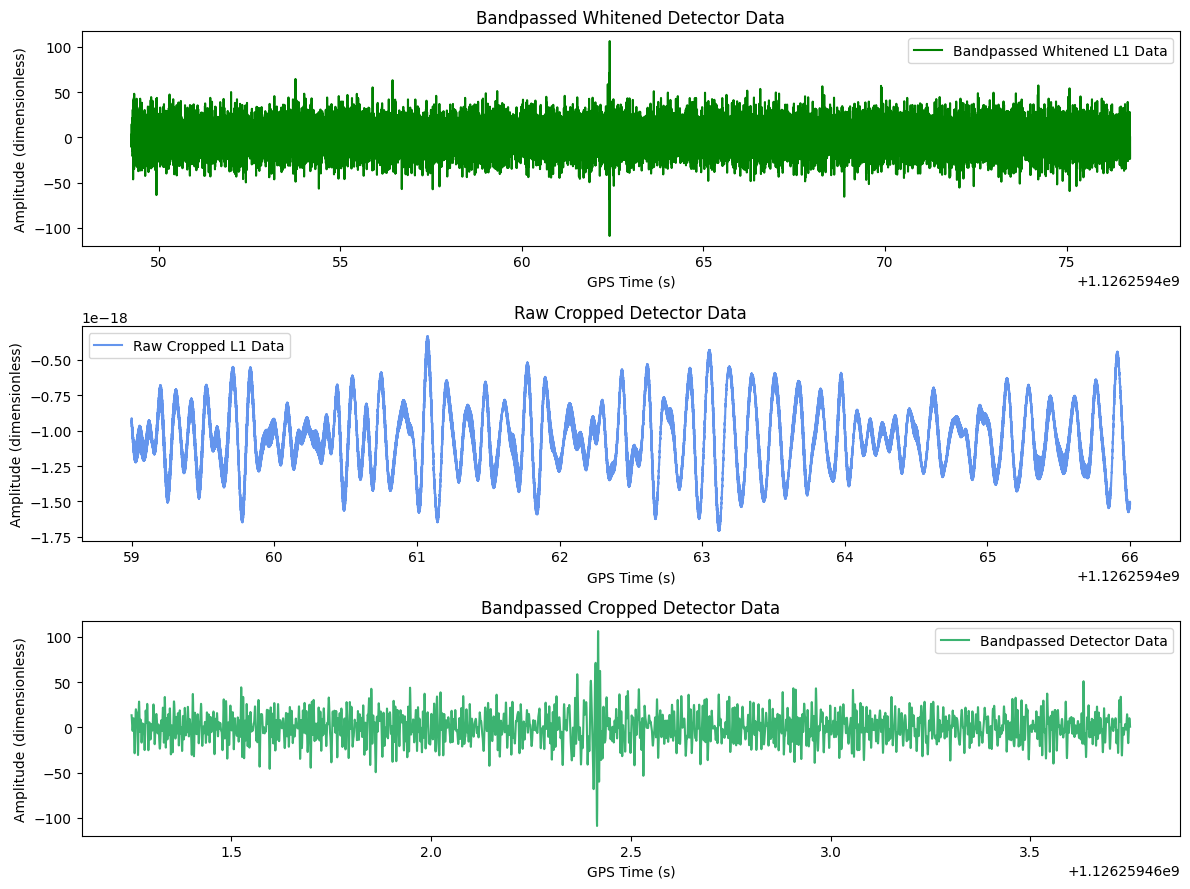

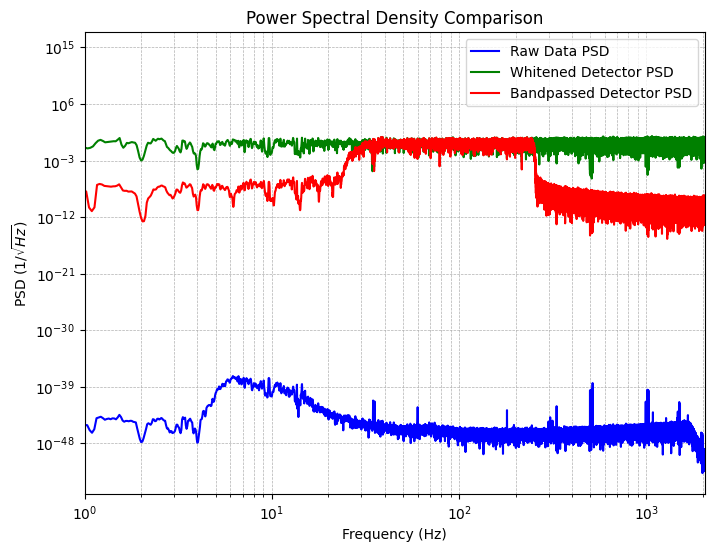

In [ ]:

# Function to apply bandpass filtering
def bandpass_data(data_input, low_cutoff=30, high_cutoff=250, order=512):

    return data_input.highpass_fir(low_cutoff, order).lowpass_fir(high_cutoff, order)

# Apply bandpass filtering
bandpassed_data = bandpass_data(whitened_data)

# Compute PSD of bandpassed data
bandpassed_psd = bandpassed_data.filter_psd(bandpassed_data.duration, bandpassed_data.delta_f, flow=1)

# Crop Data (12s on left, 13s on right)
bpsd_crop = bandpassed_data.crop(12, 13)
data_crop = data.crop(12, 13)

#========================================================================
# Plotting
#========================================================================
ffig, axes = plt.subplots(3, 1, figsize=(12, 9))  # 3 rows, 1 column

#------------------------------------------------------------------------
# Plot 1: Full Bandpassed Whitened Detector Data
#------------------------------------------------------------------------
axes[0].plot(bandpassed_data.sample_times, bandpassed_data, label='Bandpassed Whitened L1 Data', color='green')
axes[0].set_xlabel('GPS Time (s)')
axes[0].set_ylabel("Amplitude (dimensionless)")
axes[0].set_title("Bandpassed Whitened Detector Data")
axes[0].legend()

#------------------------------------------------------------------------
# Plot 2: Raw Cropped Detector Data (Left)
#------------------------------------------------------------------------
axes[1].plot(data_crop.sample_times, data_crop, label='Raw Cropped L1 Data', color='cornflowerblue')
axes[1].set_xlabel('GPS Time (s)')
axes[1].set_ylabel("Amplitude (dimensionless)")
axes[1].set_title("Raw Cropped Detector Data")
axes[1].legend()

#------------------------------------------------------------------------
# Plot 3: Bandpassed Cropped Detector Data (Right)
#------------------------------------------------------------------------
axes[2].plot(bpsd_crop.sample_times, bpsd_crop, label='Bandpassed Detector Data', color='mediumseagreen')
axes[2].set_xlabel('GPS Time (s)')
axes[2].set_ylabel("Amplitude (dimensionless)")
axes[2].set_title("Bandpassed Cropped Detector Data")
axes[2].legend()

#------------------------------------------------------------------------

plt.tight_layout()

#------------------------------------------------------------------------
# Plot 4: PSD Comparison
#------------------------------------------------------------------------
plt.figure(figsize=(8, 6))
plt.loglog(psd.get_sample_frequencies(), psd, label='Raw Data PSD', color='blue')
plt.loglog(whitened_psd.get_sample_frequencies(), whitened_psd, label='Whitened Detector PSD', color='green')
plt.loglog(bandpassed_psd.get_sample_frequencies(), bandpassed_psd, label='Bandpassed Detector PSD', color='red')

plt.xlim(flow, data.sample_rate / 2)
plt.xlabel('Frequency (Hz)')
plt.ylabel(r'PSD $(1/\sqrt {Hz})$')
plt.legend()
plt.title("Power Spectral Density Comparison")
plt.grid(which="both", linestyle="--", linewidth=0.5)

plt.show()


**Exercise 5:** Last but not least, we generate a spectrogram (time-frequency representation) using [this](https://pycbc.org/pycbc/latest/html/pycbc.types.html#pycbc.types.timeseries.TimeSeries.qtransform) function.

_Hint_: logfsteps=200, qrange=(110, 110), frange=(20, 512), vmax=3.5 as it is standard

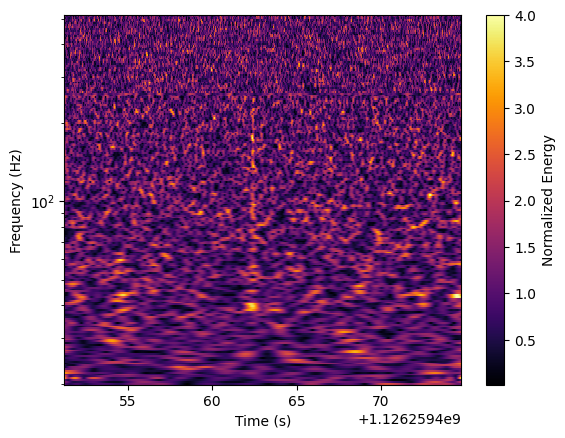

In [ ]:
#Perform a Q-transform (time-frequency representation) on the bandpassed data
times, freqs, power = bandpassed_data.qtransform(0.01, logfsteps=200, qrange=(110, 110), frange=(20, 512))

c = 200

# Plot the spectrogram using a colormap representation
# - times[c:-c]: Crops 200 time steps from both ends to reduce edge effects
# - power[:, c:-c]**0.5: Square root normalization for better visibility
# - vmax=4: Maximum intensity scale for better contrast
# - cmap="inferno": Uses the "inferno" colormap for better readability
plt.pcolormesh(times[c: -c], freqs, power[:, c:-c]**0.5, vmax=4, cmap="inferno")

plt.yscale('log')
plt.ylabel("Frequency (Hz)")
plt.xlabel("Time (s)")
plt.colorbar(label="Normalized Energy")
plt.show()


As we have seen, the detector has a given "noise budget" given  by the power spectral density (PSD), $S_{n}(f)$, according to its specific design. Let's see how the detectors will improve in the next observing runs.

**Bonus track:** From the `sensitivity_curves` folder [load](https://pycbc.org/pycbc/latest/html/pycbc.psd.html#pycbc.psd.read.from_txt) the PSD s:

- Third observing run of H1: `aligo_O3actual_H1.txt`
- Third observing run of L1: `aligo_O3actual_L1.txt`
- Third observing run of V1: `avirgo_O3actual.txt`
- Simulated fourth observing run of LIGO: `aligo_O4high.txt`

Note that these PSDs are from [LIGO public website](https://dcc.ligo.org/ligo-t2000012/public). Also read the PSD of [Einstein Telescope](https://pycbc.org/pycbc/latest/html/pycbc.psd.html#pycbc.psd.analytical.EinsteinTelescopeP1600143) (ET) and [Cosmic Explorer](https://pycbc.org/pycbc/latest/html/pycbc.psd.html#pycbc.psd.analytical.CosmicExplorerP1600143) (CE)

Plot all these PSDs. What can you say about ET and CE improvements?

_Hint_: Minimum frequency is 10 Hz, sampling rate 8192 Hz and duration is 16s.


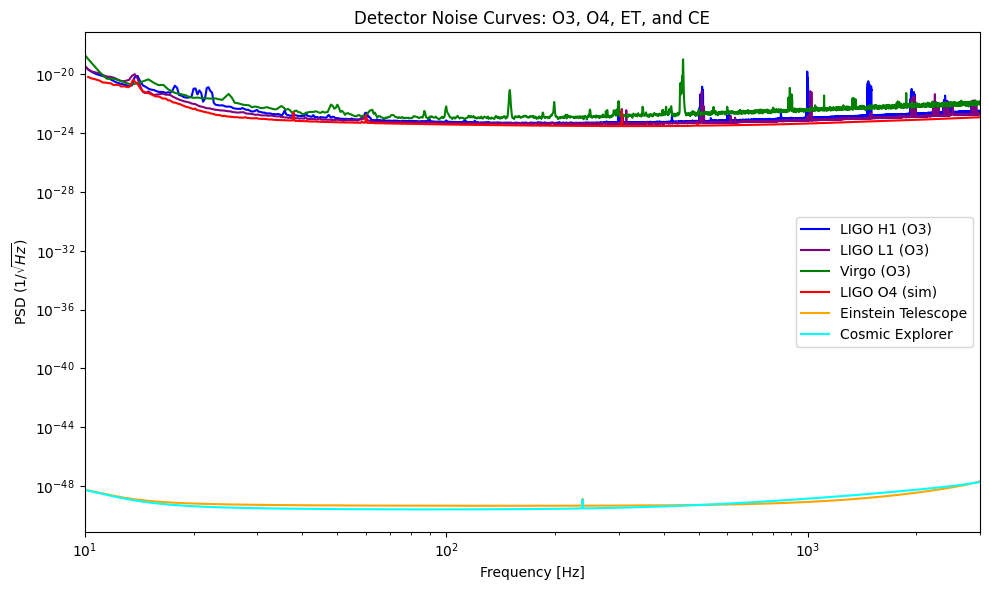

In [62]:
# Local Files
file_H1 = "/aligo_O3actual_H1.txt"
file_L1 = "/aligo_O3actual_L1.txt"
file_V1 = "/avirgo_O3actual.txt"
file_O4 = "/aligo_O4high.txt"

# Load the PSD data from text files
f_H1, psd_H1 = np.loadtxt(file_H1, unpack=True)
f_L1, psd_L1 = np.loadtxt(file_L1, unpack=True)
f_V1, psd_V1 = np.loadtxt(file_V1, unpack=True)
f_O4, psd_O4 = np.loadtxt(file_O4, unpack=True)


duration = 16 # Duration of the time series (s)

delta_f = 1/duration # delta_f (Hz)

samp_rate = 8192 # Sampling rate (Hz)

length = samp_rate * duration #Data points collected

min_frequency = 10 #(Hz)

# get the PSD values from the ET and CE function
psd_ET = pycbc.psd.analytical.CosmicExplorerWidebandP1600143(length, delta_f, min_frequency)
psd_CE = pycbc.psd.analytical.CosmicExplorerP1600143(length, delta_f, min_frequency)



plt.figure(figsize=(10, 6))

plt.loglog(f_H1, psd_H1, label="LIGO H1 (O3)", color="blue")
plt.loglog(f_L1, psd_L1, label="LIGO L1 (O3)", color="purple")
plt.loglog(f_V1, psd_V1, label="Virgo (O3)", color="green")
plt.loglog(f_O4, psd_O4, label="LIGO O4 (sim)", color="red")

plt.loglog(psd_ET.get_sample_frequencies(), psd_ET, label="Einstein Telescope", color="orange")
plt.loglog(psd_CE.get_sample_frequencies(), psd_CE, label="Cosmic Explorer",    color="cyan")

plt.xlim([10, 3000])  # Focus on 10 Hz to a few kHz
plt.xlabel("Frequency [Hz]")
plt.ylabel(r"PSD $(1/\sqrt {Hz})$")
plt.title("Detector Noise Curves: O3, O4, ET, and CE")
plt.legend(loc="best")

plt.tight_layout()
plt.show()


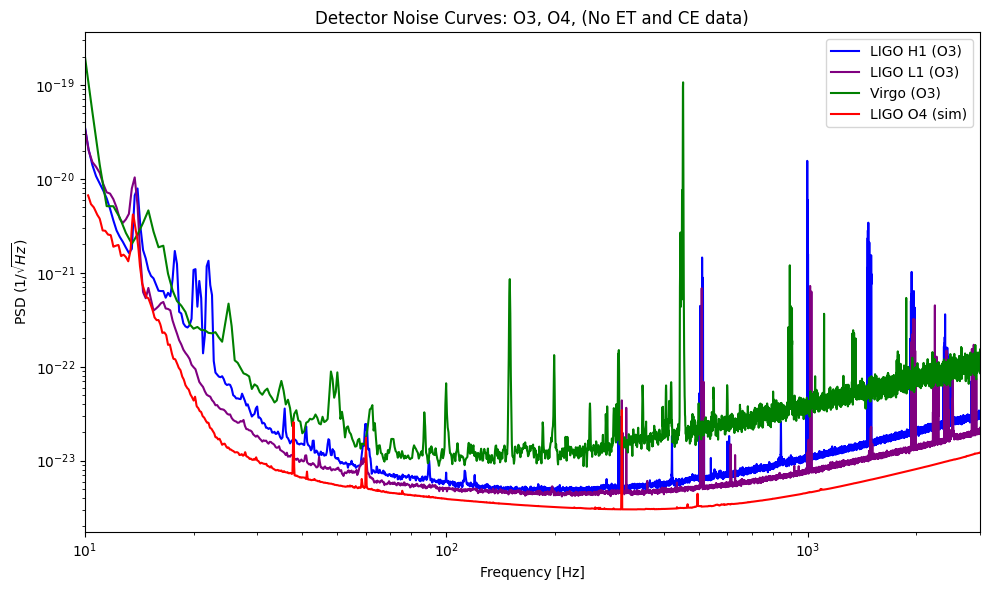

In [64]:
# PSD plots LIGO (no ET and CE data)

# Local Files
file_H1 = "/aligo_O3actual_H1.txt"
file_L1 = "/aligo_O3actual_L1.txt"
file_V1 = "/avirgo_O3actual.txt"
file_O4 = "/aligo_O4high.txt"

# Load the PSD data from text files
f_H1, psd_H1 = np.loadtxt(file_H1, unpack=True)
f_L1, psd_L1 = np.loadtxt(file_L1, unpack=True)
f_V1, psd_V1 = np.loadtxt(file_V1, unpack=True)
f_O4, psd_O4 = np.loadtxt(file_O4, unpack=True)

plt.figure(figsize=(10, 6))

plt.loglog(f_H1, psd_H1, label="LIGO H1 (O3)", color="blue")
plt.loglog(f_L1, psd_L1, label="LIGO L1 (O3)", color="purple")
plt.loglog(f_V1, psd_V1, label="Virgo (O3)", color="green")
plt.loglog(f_O4, psd_O4, label="LIGO O4 (sim)", color="red")

plt.xlim([10, 3000])  # Focus on 10 Hz to a few kHz
plt.xlabel("Frequency [Hz]")
plt.ylabel(r"PSD $(1/\sqrt {Hz})$")
plt.title("Detector Noise Curves: O3, O4, (No ET and CE data)")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

Conclusion: The plots above confirms that ET and CE will outperform current detectors in both sensitivity and frequency range. Their lower noise floors at all frequencies will allow deeper, earlier, and more precise gravitational wave observations.

Good job! This is the end of the second part. Maybe you can go for a break?